# Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW
### MUSA 650 Final Project

**Authors: Benjamin She, Eli Ericson**

In [97]:
import os, cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from glob import glob
from random import sample
from IPython.display import clear_output
from matplotlib import colors
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model

## Image preprocessing

### Define parameters and functions

In [260]:
# define read-in params

BASEDIR = 'data'

# dataset file structure has each city's images in a separate subdirectory
CITIES = ['koeln']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']

CLASSES = {
    0:'forest',
    1:'water',
    2:'agricultural',
    3:'urban_fabric',
    4:'grassland',
    5:'railway',
    6:'highway',
    7:'air_ship',
    8:'road',
    9:'building',
    10: 'non-transportation',
    11: 'transportation'}

# mapping to collapse non-transportation classes for five-class schema
classmap_5 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 2, 
    7: 3, 
    8: 4, 
    9: 0}

# mapping to assign colormap-compatible values to five-class schema
backmap_5 = {
    0: 10, 
    1: 5,
    2: 6,
    3: 7,
    4: 8}

# mapping to create binary schema (transportation vs. non-transportation)
classmap_2 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 1, 
    7: 1, 
    8: 1, 
    9: 0}

# mapping to assign colormap-compatible values to binary schema
backmap_2 = {
    0: 10, 
    1: 11 }

# display labels for plotting by number of classes
display_labels = {
    2: ['non-transportation', 'transportation'],
    5: ['non-transportation', 'railway', 'highway', 'airport/shipyard', 'road'],
    10: ['forest', 'water', 'agricultural', 'urban fabric', 'grassland', 'railway', 'highway', 
         'airport/shipyard', 'road', 'building']
}

In [3]:
# define segmentation mask color map and function to plot it
# adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

cmap = colors.ListedColormap(
    [
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
        "#f5f6f7",  # light gray for non-transportation when collapsed
        '#1292a1',  # teal for transportation when collapsed
    ]
)

cmap_norm = colors.Normalize(vmin=0, vmax=11)

In [4]:
# define mapping functions

def remap(mask, map_dict):
    """Recodes mask values according to input dict. Use to create
    reduced-class masks or to map their values back to cmap values.
    """ 
    new_mask = np.zeros_like(mask)
    
    for k, v in map_dict.items():
        new_mask[mask == k] = v
        
    return new_mask

def seg2rgb(seg_map, n_classes):
    """Converts segmentation map to plottable RGB image. """
    map_switch = {
        10: seg_map,
        5: remap(seg_map, backmap_5),
        2: remap(seg_map, backmap_2)}
    seg_map = map_switch[n_classes]
    return cmap(cmap_norm(np.squeeze(seg_map)))[:, :, :3]

In [5]:
# define read-in, display, and preprocessing functions

def read_image(dir):
    """Reads image from directory, resizes to a size divisible by
    32, and normalizes. Returns image as float array.
    """
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (1024, 1024))
    x = x.astype(np.float32)
    x /= 255
    return x

def read_mask(dir):
    """Reads segmentation mask from directory. Resizes to a size
    divisible by 32 using nearest neighbor interpolation to avoid 
    artifacts. Subtracts 1 from class values to start labels at 0, 
    not 1. Returns mask as integer array.
    """
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    x -= 1
    return x

def show_img_mask(images, masks, i, n_classes):
    """Displays an image and its mask for a given index value."""
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask']
    display_list = [images[i, ...], seg2rgb(masks[i, ...], n_classes)]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
    plt.show()

In [6]:
# get image and mask file paths, and print lengths

filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 479 - Masks: 479


### Read images and masks

In [7]:
images_full, masks_full = [], []

for imgFile in filesImg:
    images_full.append(read_image(imgFile))
for mskFile in filesMsk:
    masks_full.append(read_mask(mskFile))

images_full = np.asarray(images_full)
masks_full = np.asarray(masks_full)

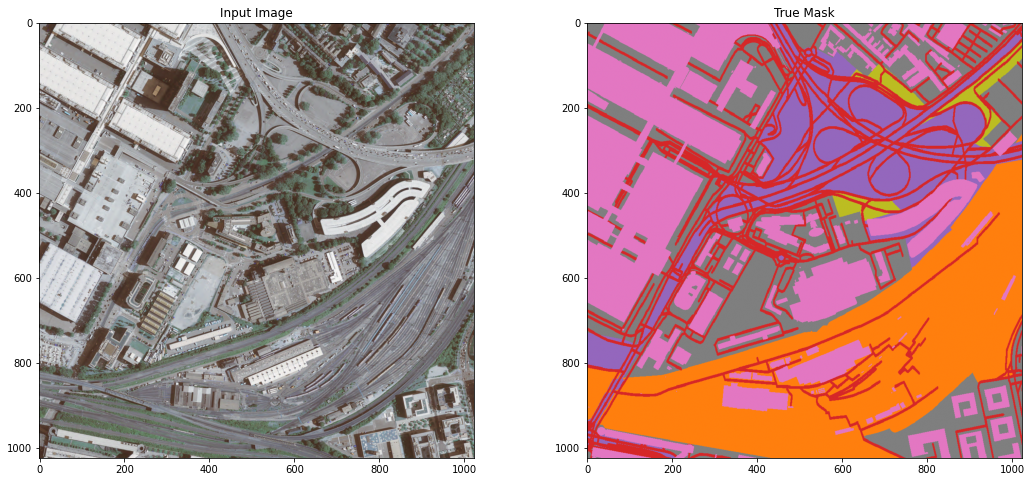

In [8]:
show_img_mask(images_full, masks_full, 266, n_classes=10)

### Split images and masks to create 10-class dataset

In [9]:
# split images and masks in 16 as orthoimagery scale is too big

images, masks = [], []

M = images_full[0].shape[0] // 4
N = images_full[0].shape[1] // 4

for im in images_full:
    images.extend([im[x:x+M, y:y+N] for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)])

for mk in masks_full:
    masks.extend([mk[x:x+M, y:y+N] for x in range(0, mk.shape[0], M) for y in range(0, mk.shape[1], N)])

images = np.asarray(images)
masks = np.asarray(masks)

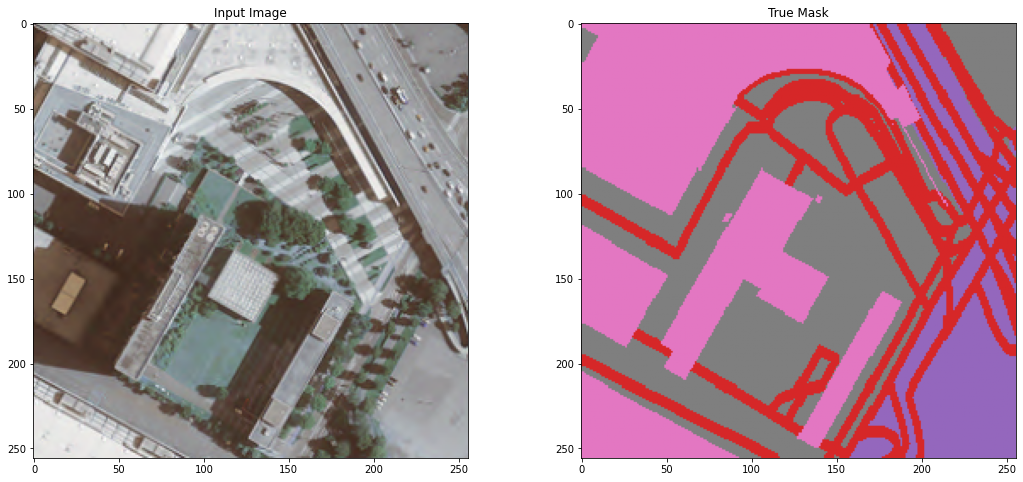

In [10]:
show_img_mask(images, masks, 4257, n_classes=10)

### Collapse non-transportation classes to create five-class masks

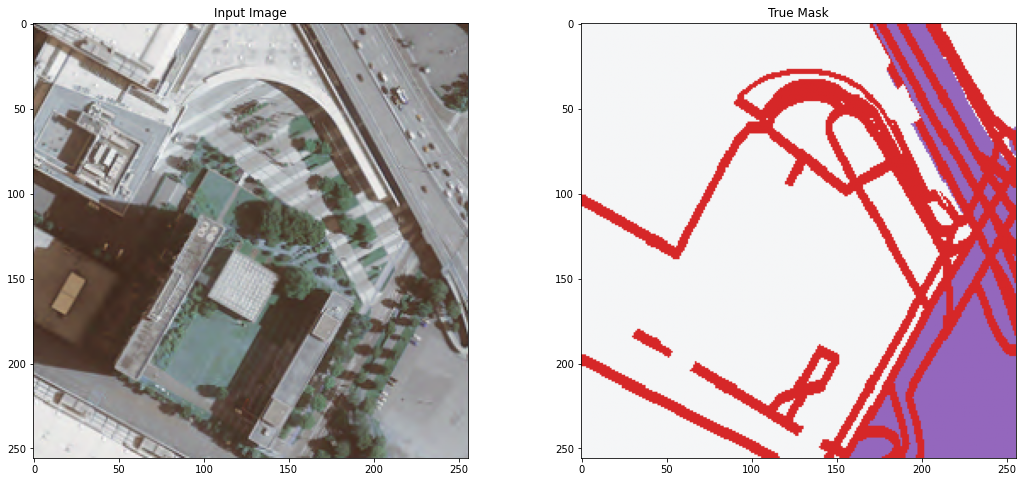

In [11]:
masks_5 = remap(masks, classmap_5)

show_img_mask(images, masks_5, 4257, n_classes=5)

### Collapse transportation and non-transportation classes to create binary masks

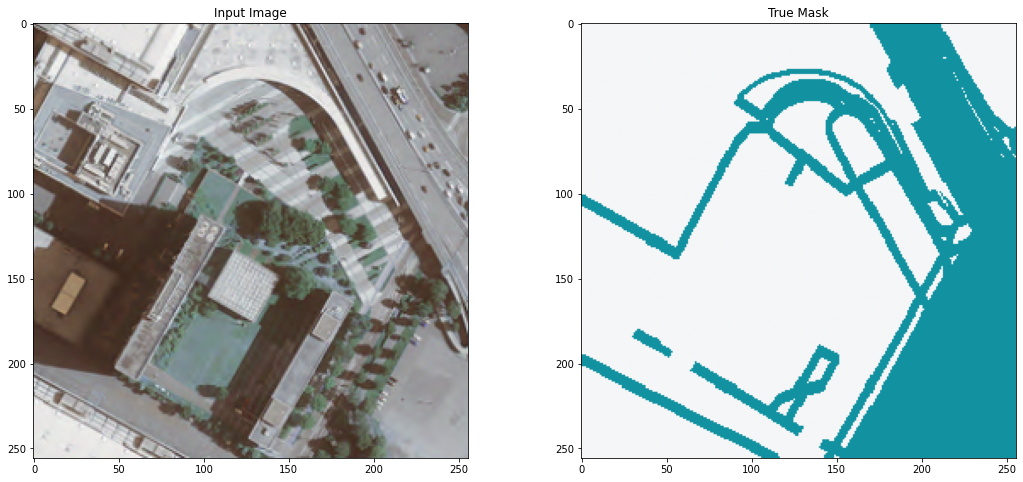

In [12]:
masks_2 = remap(masks, classmap_2)

show_img_mask(images, masks_2, 4257, n_classes=2)

## Data exploration

In [13]:
def getMaskClasses(masklist, numClasses):
    """Returns a dict with the indices of masks sorted by the number of classes
    present in them."""
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

### All classes

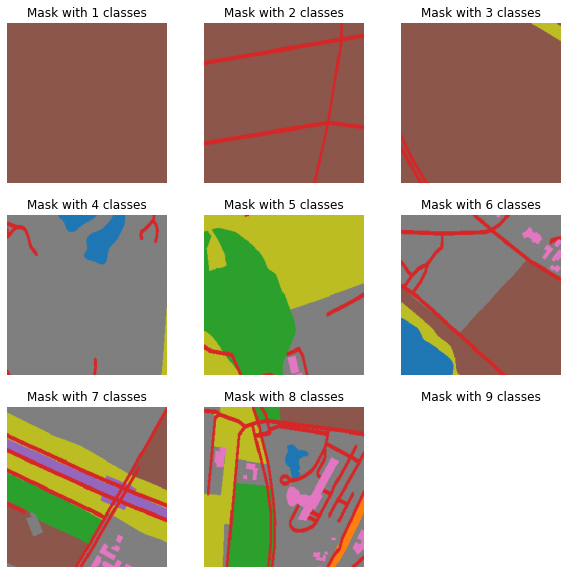

In [14]:
NUM_CLASSES =  10

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES-1):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, n_classes=NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
        ax.set_xlabel(idx)

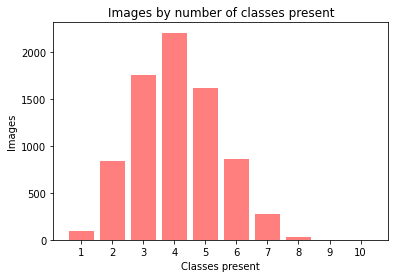

In [15]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1, NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(6, 4))
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

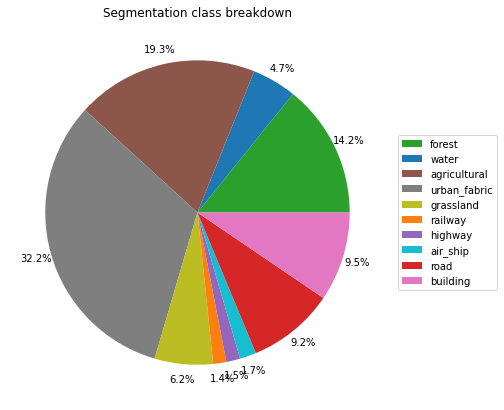

In [16]:
(classNum, counts) = np.unique(masks, return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=cmap.colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

### Reduced classes
Transportation classes distinct, all others collapsed.

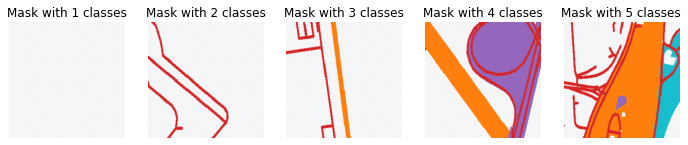

In [17]:
NUM_CLASSES = 5

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_5, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_5[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_5[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

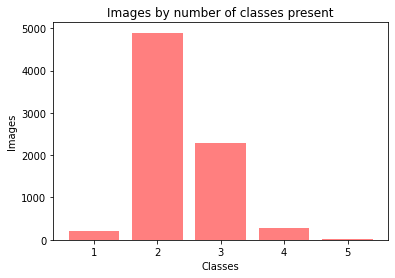

In [18]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes')
plt.title("Images by number of classes present")
plt.show()

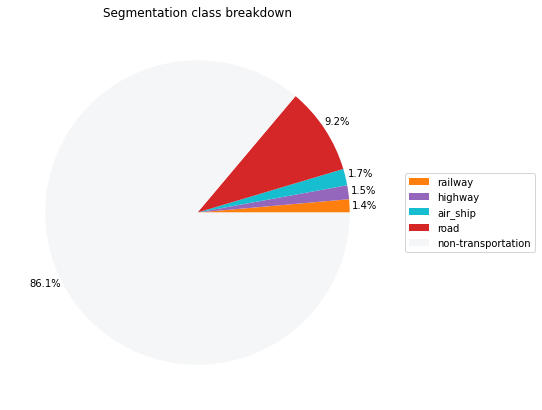

In [19]:
(classNum, counts) = np.unique(remap(masks_5, backmap_5), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors_5 = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors_5, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.show()

### Binary classes

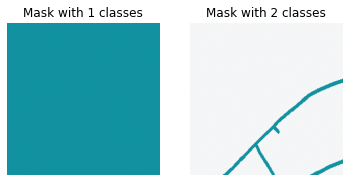

In [20]:
NUM_CLASSES = 2

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_2, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_2[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_2[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

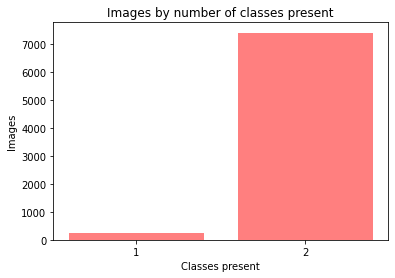

In [21]:
# get total images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

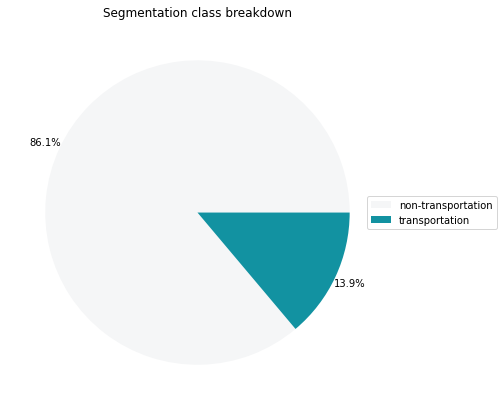

In [22]:
(classNum, counts) = np.unique(remap(masks_2, backmap_2), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

## Remove images with few transportation pixels

### All classes

In [ ]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1, NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(6, 4))
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

### Reduced classes

### Binary classes

## U-Net models

In [23]:
# define params

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 4

In [24]:
# define U-Net building blocks and function
# adapted from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

def downsample_block(x, n_filters, dropout=0.1):
    f = double_conv_block(x, n_filters, dropout)
    p = MaxPooling2D(2)(f)
    return f, p

def double_conv_block(x, n_filters, dropout):
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    return x

def upsample_block(x, conv_features, n_filters, dropout=0.1):
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(x)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters, dropout)
    return x

def build_unet():    
    # inputs
    inputs = Input(shape=INPUT_SHAPE)
    
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0.1)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.1)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.2)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.2)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.3)
    
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.2)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.2)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.1)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0.1)
    
    # outputs
    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation = "softmax")(u9)
    
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [25]:
# redefine Keras MIoU to work with sparse categorical crossentropy
# drawn from https://stackoverflow.com/a/61826074/6221738

class miou(tf.keras.metrics.MeanIoU):
    def __init__(self,
                 y_true=None,
                 y_pred=None,
                 num_classes=None,
                 name=None,
                 dtype=None):
        super(miou, self).__init__(num_classes=num_classes,name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [249]:
# define functions and callback to display sample prediction
# adapted from https://www.tensorflow.org/tutorials/images/segmentation

def display_sample(display_list):
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        if i > 0:
            display_list[i] = seg2rgb(display_list[i], NUM_CLASSES)
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image[tf.newaxis, ...])
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display_sample([sample_image, sample_mask, pred_mask])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [28]:
# define function to plot loss by epoch
# adapted from https://www.tensorflow.org/tutorials/images/segmentation

def plot_loss_history():
    """Plots training and validation loss by epoch."""
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure()
    plt.plot(model_history.epoch, loss, 'b', label='Training loss')
    plt.plot(model_history.epoch, val_loss, '--r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

In [250]:
# define function to plot multiple predictions on a grid
# figured this one out myself!

def show_prediction_grid(X, y_true, y_pred, idx_list):
    """Plots a grid of images, masks, and segmentations."""
    
    cols = ['Input Image', 'True Mask', 'Predicted Mask']

    fig, axes = plt.subplots(ncols=3, nrows=len(idx_list), figsize=(9, len(idx_list) * 3))

    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for i in range(len(idx_list)):
        idx = idx_list[i]
        img = X[idx]
        msk = seg2rgb(y_true[idx], NUM_CLASSES)
        pred = seg2rgb(y_pred[idx], NUM_CLASSES)
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(msk)
        axes[i, 2].imshow(pred)
        [axi.set_axis_off() for axi in axes.ravel()]

    fig.tight_layout()

### Binary segmentation

In [148]:
NUM_CLASSES=2

model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 256, 256, 32) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 9248        dropout_36[0][0]                 
______________________________________________________________________________________________

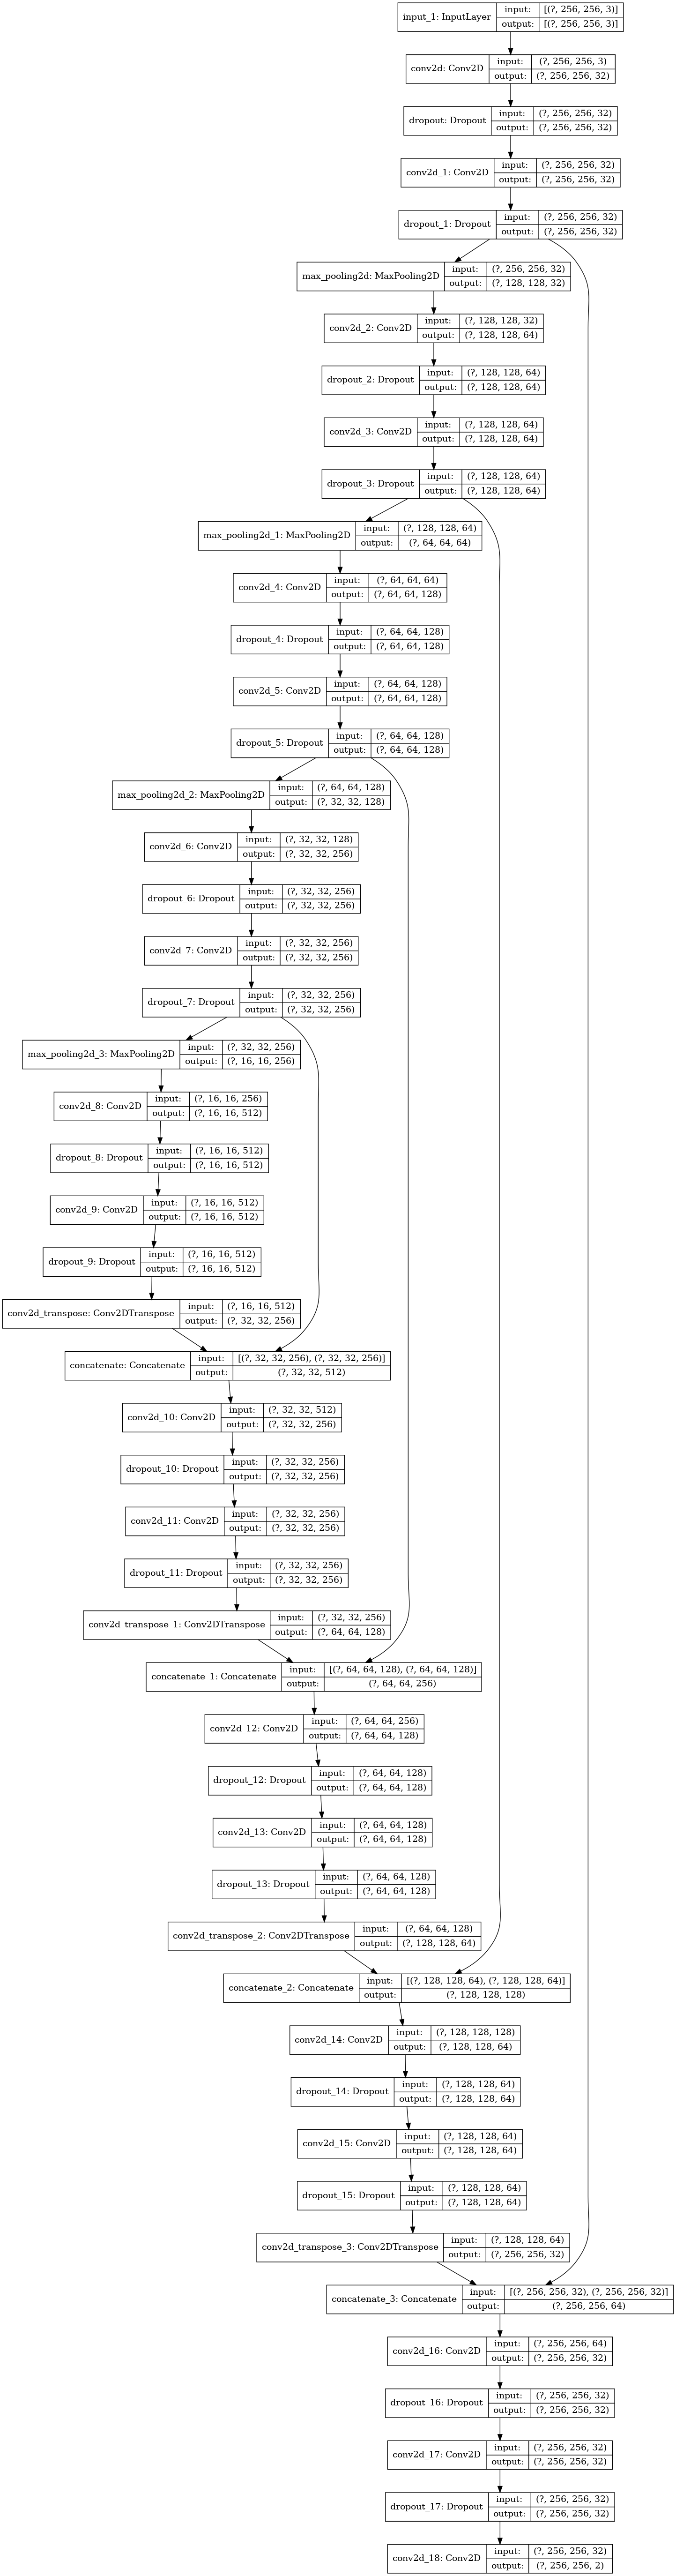

In [30]:
plot_model(model, show_shapes=True, show_layer_names=True)

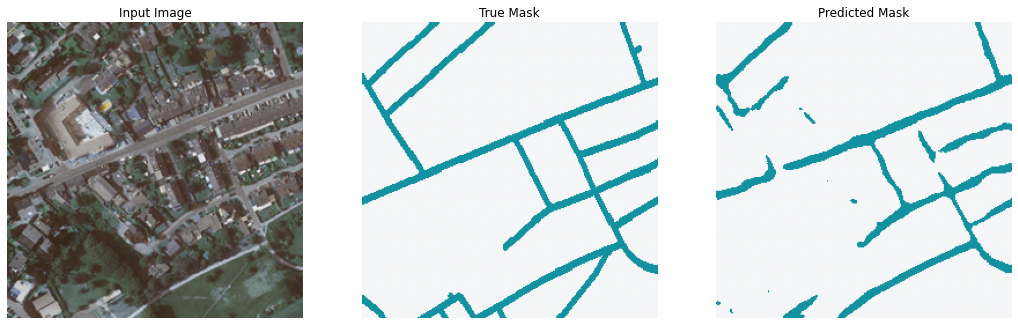


Sample Prediction after epoch 40

100/100 [==============================] - 9s 89ms/step - loss: 0.1447 - miou_3: 0.7285 - accuracy: 0.9444 - val_loss: 0.1970 - val_miou_3: 0.6939 - val_accuracy: 0.9296


In [149]:
NUM_CLASSES = 2

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images[500:1000],
    masks_2[500:1000],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[99], y_tr[99])

NUM_EPOCHS = 40
# TRAIN_SIZE = len(X_tr)
# TEST_SIZE = len(X_te)
# STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
# VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=20, verbose=1),
    # reduce learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

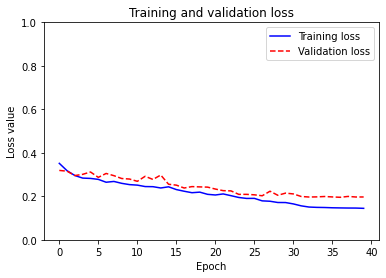

In [150]:
plot_loss_history()

##### Examine a sample prediction

25/25 [==============================] - 0s 17ms/step


In [152]:
def print_iou():
    jaccard_tr = jaccard_score(y_tr.flatten(), segmentations_tr.flatten(), average=None)
    jaccard_te = jaccard_score(y_te.flatten(), segmentations_te.flatten(), average=None)

    for i in range(NUM_CLASSES):
        print(f'class {i}: {display_labels[NUM_CLASSES][i]}')
        print(f'training IOU: {round(jaccard_tr[i], 3)}')
        print(f'test IOU: {round(jaccard_te[i], 3)}\n')

#### Jaccard score (intersection over union) by class

In [153]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=1)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=1)
segmentations_te = np.argmax(predictions_te, axis=-1)

print_iou()

class 0: non-transportation
training IOU: 0.943
test IOU: 0.925

class 1: transportation
training IOU: 0.538
test IOU: 0.463



#### Plot sample predictions

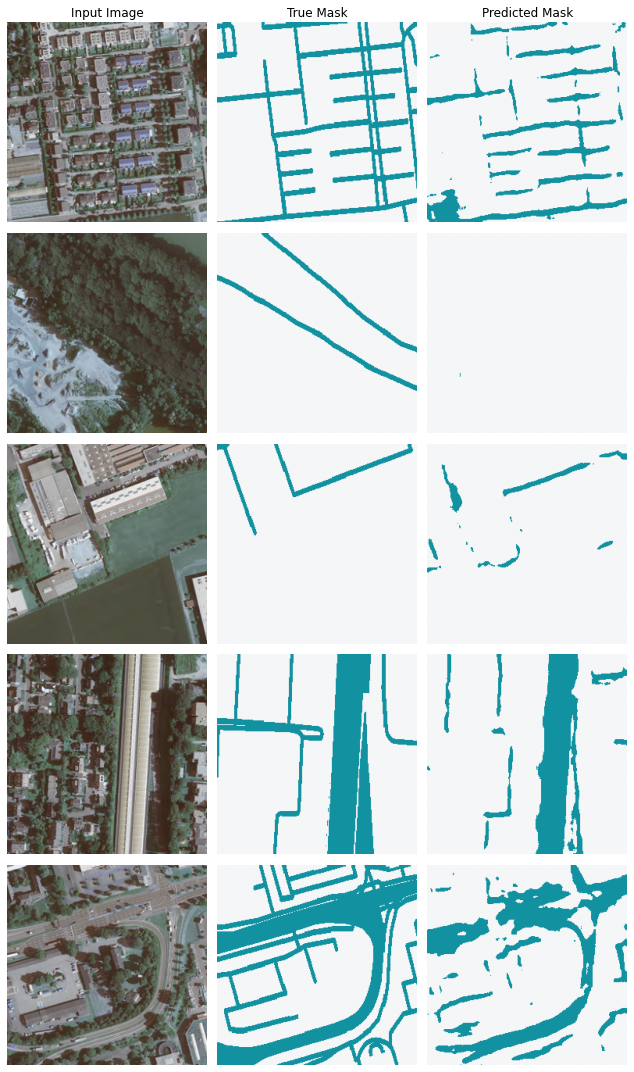

In [246]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list)

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Plot predictions by channel

In [ ]:
prediction = predictions_te[0]
segmentation = segmentations_te[0]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(3, NUM_CLASSES))
plt.suptitle('Predictions by channel')
#[axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(i)

In [ ]:
# predictions_2_tr = model.predict(X_tr, batch_size=4, verbose=1)
# segmentations_2_tr = np.argmax(predictions_2, axis=-1)

predictions_2 = model.predict(X_te, batch_size=4, verbose=1)
segmentations_2 = np.argmax(predictions_2, axis=-1)

In [ ]:
predictions = model.predict(X_te, batch_size=4, verbose=1)
segmentations = np.argmax(predictions, axis=-1)

In [ ]:
display_sample([X_te[0], y_te[0], segmentations_2[0]])

In [ ]:
display_sample([X_te[0], y_te[0], segmentations_2[0]])

In [ ]:
for idx in idx_list:
    display_sample([X_te[idx], y_te[idx], segmentations_2[idx]])

In [ ]:
# prediction = model(np.expand_dims(X_tr[0], 0)).numpy()
# segmentation = np.argmax(prediction, axis=-1)

prediction = predictions_2[0]
segmentation = segmentations_2[0]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(3, NUM_CLASSES))
plt.suptitle('Predictions by channel')
#[axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(i)

In [ ]:
prediction = model(np.expand_dims(X_tr[0], 0)).numpy()
segmentation = np.argmax(prediction, axis=-1)

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(3, NUM_CLASSES))
# [axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    plt.xticks([])
    plt.yticks([])

In [ ]:
plt.imshow(np.squeeze(prediction[..., 1]), vmin=0, vmax=1, cmap='pink')

In [ ]:
display_sample([X_tr[0], y_tr[0], segmentation])

In [ ]:
test_prediction = model(np.expand_dims(X_te[1], 0)).numpy()
test_segmentation = np.argmax(test_prediction, axis=-1)

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(3, NUM_CLASSES))
# [axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(test_prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    plt.xticks([])
    plt.yticks([])

In [ ]:
display_sample([X_te[1], y_te[1], test_segmentation])

In [ ]:
for i in range(NUM_CLASSES):
    min_ = np.min(prediction[..., i])
    max_ = np.max(prediction[..., i])
    mean = np.mean(prediction[..., i])
    std = np.std(prediction[..., i])
    print(f"Channel {i} min is {min_}, max is {max_}, mean is {mean}, std is {std}")

##### Plot pixel-level errors by class

In [ ]:
predictions = model.predict(X_te, batch_size=4, verbose=1)
segmentations = np.argmax(predictions, axis=-1)

In [ ]:
predictions = model.predict(X_te, batch_size=4, verbose=1)
segmentations = np.argmax(predictions, axis=-1)

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Second model: Weighted loss function

In [ ]:
class_counts = np.unique(masks_2, return_counts=True)
max_count = np.max(class_counts)
class_weights = [max_count / class_count for class_count in class_counts]

In [ ]:
class_nums, class_counts = np.unique(masks_2, return_counts=True)

In [ ]:
max_count = max(class_counts)

class_weights = [max_count / class_count for class_count in class_counts]

In [ ]:
class_weights

In [ ]:
def get_class_weights(masks):
    """Computes weights to counter class imbalances. Returns
    dict to use as model.fit parameter."""
    
    classes, counts = np.unique(masks, return_counts=True)
    max_count = np.max(counts)
    weights = [max_count / count for count in counts]
    class_weights = dict(zip(classes, weights))
    
    return class_weights

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=2), "accuracy"])

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(
    images[:500],
    masks_2[:500],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

class_weight = get_class_weights(y_tr)

sample_image, sample_mask = (X_tr[42], y_tr[42])

NUM_EPOCHS = 100
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss', patience=20, verbose=1),
    # to save checkpoints
    # ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

## Multiclass dice loss experiment

In [ ]:
def get_class_weights(masks):
    """Computes weights to counter class imbalances. 
    Returns list of weights."""
    
    classes, counts = np.unique(masks, return_counts=True)
    max_count = np.max(counts)
    weights = [max_count / count for count in counts]
    
    return weights

In [ ]:
def weighted_crossentropy(class_weights: list, is_logits: bool=False):
    """
    Multi-class weighted cross entropy.
        WCE(p, p̂) = −Σp*log(p̂)*class_weights
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Weight coefficients (list of floats)
    :param is_logits: If y_pred are logits (bool)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: Ground truth (tf.Tensor, shape=(None, None, None, None))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        assert len(class_weights) == y_pred.shape[-1], f"Number of class_weights ({len(class_weights)}) needs to be the same as number " \
                                                 f"of classes ({y_pred.shape[-1]})"

        if is_logits:
            y_pred = softmax(y_pred, axis=-1)

        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())  # To avoid unwanted behaviour in K.log(y_pred)

        # p * log(p̂) * class_weights
        wce_loss = y_true * K.log(y_pred) * class_weights

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return -wce_loss

    return loss

In [ ]:
NUM_CLASSES=2

model = build_unet()

from tensorflow.keras.utils import to_categorical

masks_2_onehot = to_categorical(masks_2)

X_tr, X_te, y_tr, y_te = train_test_split(
    images[:500],
    masks_2_onehot[:500],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[42], y_tr[42])

class_weights = get_class_weights(masks_2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=weighted_crossentropy(class_weights=class_weights),
              metrics=[miou(num_classes=2), "accuracy"])

NUM_EPOCHS = 100
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss', patience=20, verbose=1),
    # to save checkpoints
    # ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

### Multiclass segmentation: Five classes

In [293]:
NUM_CLASSES=5

model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 256, 256, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_90 (Dropout)            (None, 256, 256, 32) 0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 32) 9248        dropout_90[0][0]                 
______________________________________________________________________________________________

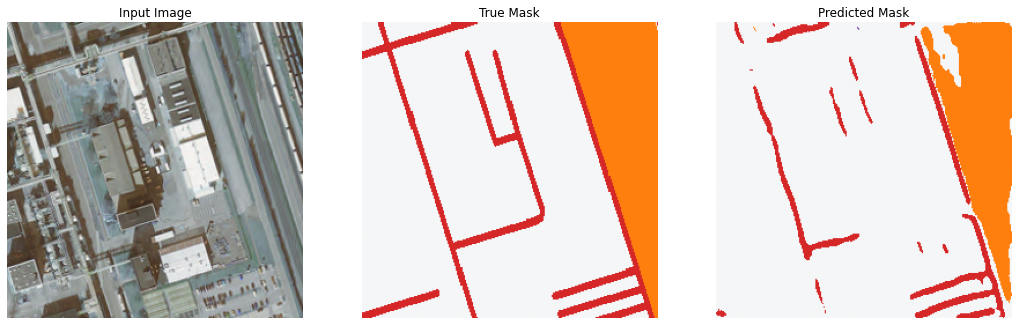


Sample Prediction after epoch 40

100/100 [==============================] - 9s 92ms/step - loss: 0.1627 - miou_7: 0.6282 - accuracy: 0.9418 - val_loss: 0.2200 - val_miou_7: 0.5356 - val_accuracy: 0.9288


In [294]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images[500:1000],
    masks_5[500:1000],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[58], y_tr[58])

NUM_EPOCHS = 40
# TRAIN_SIZE = len(X_tr)
# TEST_SIZE = len(X_te)
# STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
# VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=20, verbose=1),
    # reduce learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

#### Loss curve

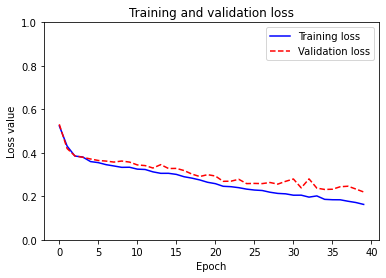

In [295]:
plot_loss_history()

#### Jaccard score (intersection over union) by class

In [298]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

print_iou()

class 0: non-transportation
training IOU: 0.947
test IOU: 0.931

class 1: railway
training IOU: 0.721
test IOU: 0.39

class 2: highway
training IOU: 0.551
test IOU: 0.402

class 3: airport/shipyard
training IOU: 0.487
test IOU: 0.42

class 4: road


IndexError: index 4 is out of bounds for axis 0 with size 4

#### Pixel-level confusion matrix

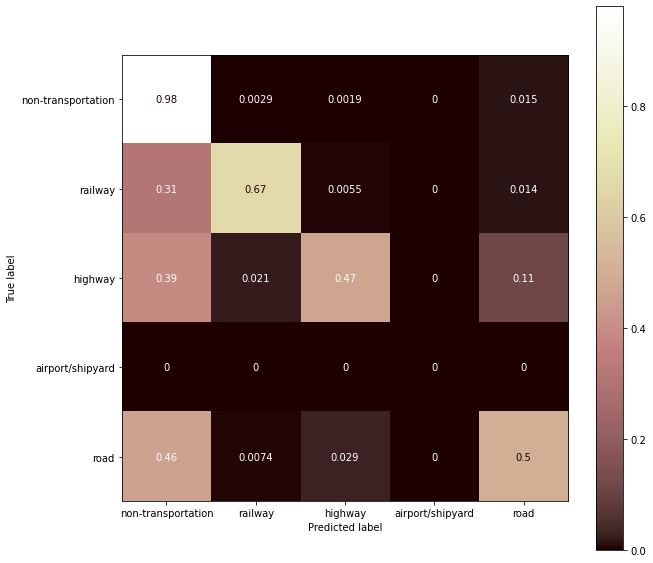

In [300]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels[NUM_CLASSES], 
                                        normalize='true', cmap='pink', ax=ax)

#### Plot sample predictions

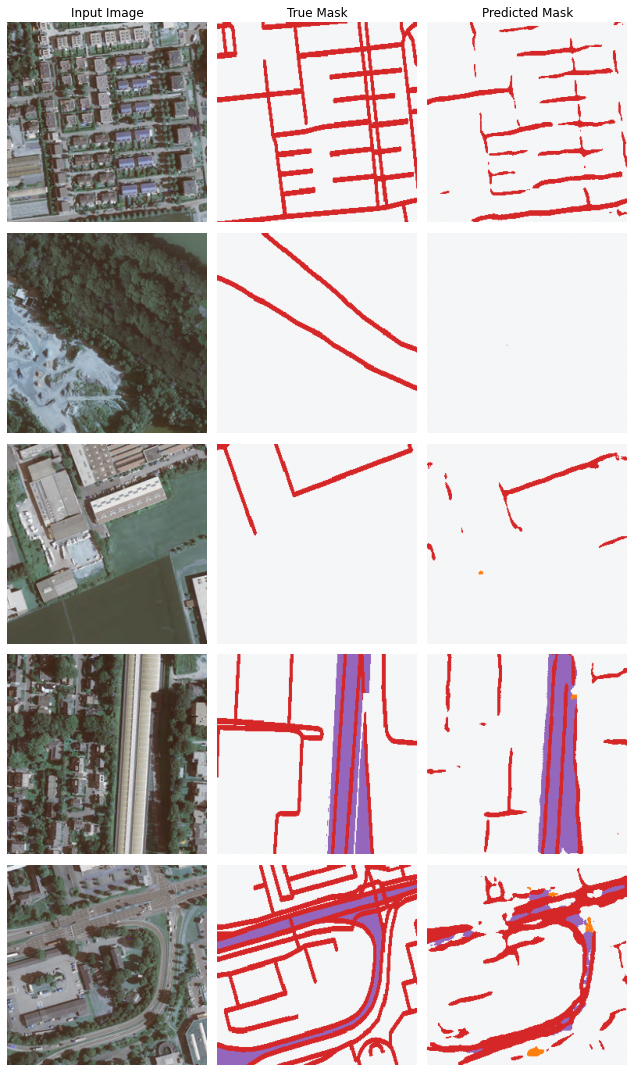

In [301]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list)

#### Plot predictions by channel

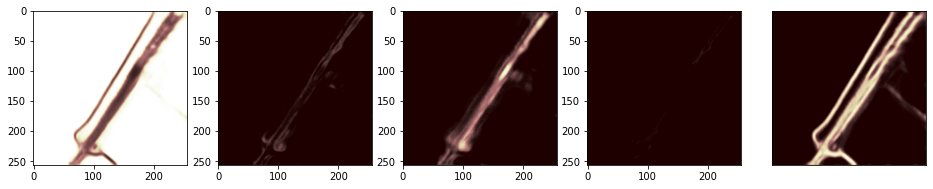

In [304]:
prediction = predictions_te[58]
segmentation = segmentations_te[58]

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, NUM_CLASSES))
# [axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    plt.xticks([])
    plt.yticks([])

In [ ]:
prediction = model(np.expand_dims(X_tr[0], 0)).numpy()
segmentation = np.argmax(prediction, axis=-1)

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, NUM_CLASSES))
# [axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    plt.xticks([])
    plt.yticks([])

### Multiclass segmentation: 10 classes

In [312]:
NUM_CLASSES=10

model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 256, 256, 32) 896         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_144 (Dropout)           (None, 256, 256, 32) 0           conv2d_152[0][0]                 
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 256, 256, 32) 9248        dropout_144[0][0]                
______________________________________________________________________________________________

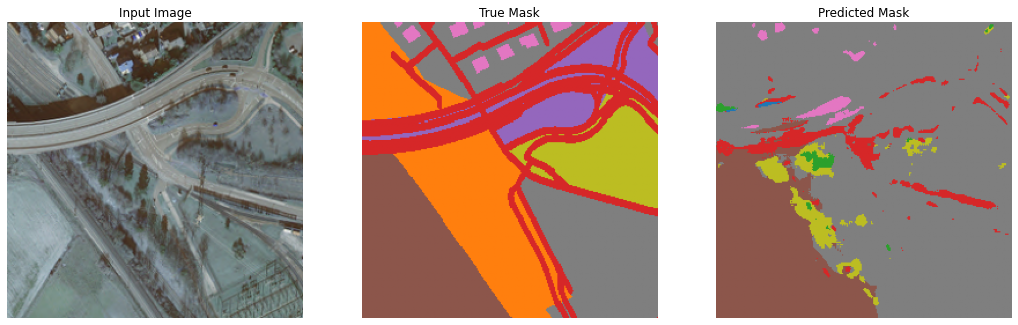


Sample Prediction after epoch 38


Epoch 00038: ReduceLROnPlateau reducing learning rate to 5.000000413701855e-09.
100/100 [==============================] - 9s 93ms/step - loss: 0.7174 - miou_10: 0.3622 - accuracy: 0.7416 - val_loss: 0.9865 - val_miou_10: 0.3289 - val_accuracy: 0.6688
Epoch 00038: early stopping


In [313]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalCrossentropy(from_logits=False,
                                                 reduction="auto",
                                                 name="sparse_categorical_crossentropy"),
              metrics=[miou(num_classes=NUM_CLASSES), "accuracy"])

X_tr, X_te, y_tr, y_te = train_test_split(
    images[500:1000],
    masks[500:1000],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[42], y_tr[42])

NUM_EPOCHS = 40
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
# STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
# VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # stop training early if loss stops improving
    EarlyStopping(monitor = 'val_loss', patience=20, verbose=1),
    # reduces learning rate if loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

#### Loss curve

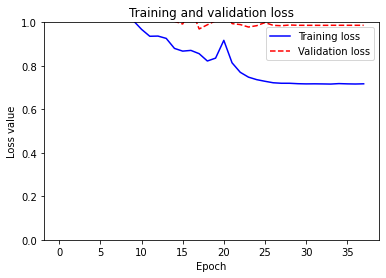

In [314]:
plot_loss_history()

#### Jaccard score (intersection over union) by class

In [ ]:
predictions_tr = model.predict(X_tr, batch_size=4, verbose=0)
segmentations_tr = np.argmax(predictions_tr, axis=-1)

predictions_te = model.predict(X_te, batch_size=4, verbose=0)
segmentations_te = np.argmax(predictions_te, axis=-1)

print_iou()

#### Pixel-level confusion matrix

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))

ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations_te.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels(NUM_CLASSES), 
                                        normalize='true', cmap='pink', ax=ax)

#### Plot sample predictions

In [ ]:
show_prediction_grid(X_te, y_te, segmentations_te, idx_list)

In [ ]:
predictions = model.predict(X_te, batch_size=4, verbose=1)
segmentations = np.argmax(predictions, axis=-1)

fig, ax = plt.subplots(figsize=(14, 14))
display_labels = ['forest', 'water', 'agricultural', 'urban fabric', 'grassland', 'railway', 'highway', 
                  'airport/shipyard', 'road', 'building']
ConfusionMatrixDisplay.from_predictions(y_te.flatten(), segmentations.flatten(), 
                                        labels=range(NUM_CLASSES), display_labels=display_labels, normalize='true',
                                        cmap='pink', ax=ax)

In [ ]:
prediction = model(np.expand_dims(X_tr[0], 0)).numpy()
segmentation = np.argmax(prediction, axis=-1)

fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, NUM_CLASSES))
# [axi.set_axis_off() for axi in axs.ravel()]
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), vmin=0, vmax=1, cmap='pink')
    plt.xticks([])
    plt.yticks([])

In [ ]:
display_sample([X_tr[0], y_tr[0], segmentation])

In [ ]:
display_sample([X_tr[0], y_tr[0], segmentation])

## Reducing class imbalance

In [ ]:
# get per-image share of pixels in transportation classes
img_size = images[0].size
pct_transportation = [(mask == 1).sum()/img_size for mask in masks_2]

plt.hist(pct_transportation, bins=30, color='red', alpha=0.5)
plt.title('Images by share of transportation pixels')
plt.show()

In [ ]:
# delete images and masks with fewer than 2% of pixels in transportation classes
low_transpo_idx = np.where(np.asarray(pct_transportation) < 0.05)[0]

def delete_low_transpo(array):
    new_array = np.delete(array, low_transpo_idx, axis=0)
    return new_array

In [ ]:
images = delete_low_transpo(images)
masks = delete_low_transpo(masks)
masks_5 = delete_low_transpo(masks_5)
masks_2 = delete_low_transpo(masks_2)

### All classes

In [ ]:
NUM_CLASSES =  10

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES-1):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, n_classes=NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
        ax.set_xlabel(idx)
        
(classNum, counts) = np.unique(masks, return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=cmap.colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

### Reduced classes

In [ ]:
NUM_CLASSES = 5

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_5, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_5[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_5[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

(classNum, counts) = np.unique(remap(masks_5, backmap_5), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors_5 = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors_5, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.show()

### Binary classes

In [ ]:
NUM_CLASSES = 2

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_2, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_2[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_2[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
plt.show()        

# get total images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# get reduced color map to match classes
colors = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()